# Hallucinating the Constitution

EE P 502 - Autumn 2019 - HW 10  
Steve Lambert

Consider the constitution of the United States:

> https://www.usconstitution.net/const.txt .

This document contains upper- and lower-case letters, numbers, and basic punctuation. 

**One letter prediction:**

1. Find the set of all characters used in the document. Call the number of characters $n$. 
2. Create an $n \times n$ matrix whose $i,j$ entry is the probability that the next character is $j$ given that the current character is $i$. Estimate this probability by looking at all occurrences of character $i$ in the document and the number of times character $j$ immediately follows it. 
3. Simulate this system as a Markov chain that starts with an arbitrary capital letter and continues until it gets to a space. Produce $100$ random "words" this way. How many of them are actual words? Use a [Scrabble dictionary](https://scrabble.hasbro.com/en-us/tools#dictionary) if you are not certain whether a given sequence is a word. 

**Two letter prediction:**

1. Create an $n \times n \times n$ tensor whose $i,j,k$ entry is the probability that the next character is $k$ given that the current character is $j$ and the previous character is $i$. Use the document to empirically find these probabilities. 
2. Use this model to construct random words. 

**Sentence prediction:**

Do a one word prediction, but use all the unique *words* in the document. Hallucinate sentences. Consider a punctuation mark as a word. 

**Notes:** Use `open` and `file.read` to read in the file as a string. For the sentence. Use `replace` to add space before punctuation and then `split()` to turn the string into a list. Use a `DiGraph` from the `networkx` library to store the data. Note that you can make weighted edges by adding data to the edges, as in [this document](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_weighted_graph.html).

# Setup

First, let's import the packages we'll need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
import sympy as sm
sm.init_printing(use_latex='mathjax')
%matplotlib inline

To make word checking easier and faster, we can compare our results against a dictionary from nltk. We can then check for words in the way shown below.

In [2]:
# Downloading and importing the packages

import nltk # can use to check for words
nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
# Quick test

'constitution' in words.words()

True

After saving the constitution to a local text file, we can easily load it into python using `open` and `file.read`.

I used a second file 'constitution_small.txt', which contains only the first line of the constitution, to run tests.

In [4]:
# Loading the constitution text file and storing it in the variable 'text'

file = open('constitution_full.txt',mode='r') # entire constitution
file1 = open('constitution_small.txt', mode='r') # first line only, for testing
text = file.read() # save the data as a string
text_short = file1.read()
file.close()
file1.close()

Finally, to finish setting up, we will need a way to map back and forth between characters and integers. I chose to use two python dictionaries: one with keys as the characters and the other with keys as the integers. To find the unique characters used in the constitution, I looped through the entire file and added them to a set (this is done below with the variable `char_set`). The index order is the order that the set printed them in, so I used that. 

Note: X and Z never appear in the constitution. I added them to the map for completeness, but this will cause issues later on.

In [5]:
# Dictionary for mapping characters to integers (indices)

char_map = {'\n' : 0,
 ' ': 1,
 '"': 2,
 '(': 3,
 ')': 4,
 ',': 5,
 '-': 6,
 '.': 7,
 '0': 8,
 '1': 9,
 '2': 10,
 '3': 11,
 '4': 12,
 '5': 13,
 '6': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 ':': 18,
 ';': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'X': 43,
 'Y': 44,
 'Z': 45,
 'a': 46,
 'b': 47,
 'c': 48,
 'd': 49,
 'e': 50,
 'f': 51,
 'g': 52,
 'h': 53,
 'i': 54,
 'j': 55,
 'k': 56,
 'l': 57,
 'm': 58,
 'n': 59,
 'o': 60,
 'p': 61,
 'q': 62,
 'r': 63,
 's': 64,
 't': 65,
 'u': 66,
 'v': 67,
 'w': 68,
 'x': 69,
 'y': 70,
 'z': 71}

# Reversing the above to get a dictionary from integers (indices) to characters
int_map = dict((reversed(item) for item in char_map.items()))


# Data Collection

Because the one letter and two letter prediction problems use matrices, they can be computed at the same time by setting up the data correctly. 

First, let's determine how to store the needed data for the one letter problem. We need an "$n \times n$ matrix whose $i,j$ entry is the probability that the next character is $j$ given that the current character is $i$." $n$ in this case is $72$ because that is the number of unique characters (and the max value in the dictionary above).

So, we will use a $72\times 72$ matrix and initialize it with zeros. Each row represents the current character and each column represents the next character.

To find the probability that a certain character follows another, we need the total number of times each unique character appears in the text and the total number of time each unique character follows that first character. 

So, our first data structure will be a $72\times 72$ matrix that tracks character occurences in this way. From that matrix, we can compute probabilities. So we will need a second matrix to store the probabilities.


In [6]:
# Initializing matrices for one letter problem

one_letter_counts = np.zeros((72,72))
one_letter_probs = np.zeros((72,72))

To fill these matrices, we loop through the text file character by character. This is demonstrated with the test file:

In [7]:
# Looping through the test file and printing each character

test = []
for char in text_short:
    test.append(char)
print(test)

['W', 'e', ' ', 't', 'h', 'e', ' ', 'P', 'e', 'o', 'p', 'l', 'e', ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 'U', 'n', 'i', 't', 'e', 'd', ' ', 'S', 't', 'a', 't', 'e', 's', ',', ' ', 'i', 'n', ' ', 'O', 'r', 'd', 'e', 'r', ' ', 't', 'o', ' ', 'f', 'o', 'r', 'm', ' ', 'a', ' ', 'm', 'o', 'r', 'e', ' ', 'p', 'e', 'r', 'f', 'e', 'c', 't', ' ', 'U', 'n', 'i', 'o', 'n', ',', '\n', '\n', '\n']


While we loop through the entire constitution, we need to keep track of the previous character. Then, on each loop, we increment the `[previous,current]` entry of our counting matrix by one. (`previous` and `current` are characters, so they are translated to integers using the dictionary we created).

Before implementing this loop, we can consider the two letter problem. If the necessary data can be gathered for both problems in a single loop, that is much more efficient. 

Much of the process is the same, but for two letters, we need "an $n \times n \times n$ tensor whose $i,j,k$ entry is the probability that the next character is $k$ given that the current character is $j$ and the previous character is $i$."

So, we will use a $72 \times 72 \times 72$ matrix and initialize it with zeros. This time, the rows representing the next character are stored in the $i$, $j$ location in the matrix. $j$, the "columns", represents the previous character and $i$, the "rows", represents the character two spots in front of the current character.

In [8]:
# Initializing the matrices for the two letter problem

two_letter_counts = np.zeros((72,72,72))
two_letter_probs = np.zeros((72,72,72))

For the single letter problem, we needed to track only the immediately previous character. This is simple to do with a single variable. For the two letter problem, we need to track the previous two characters. For this, I used a `deque`, a double-ended queue. By setting the max size to $2$ and appending the current character on each loop, this variable always stored the last two characters. 

In [9]:
# Importing deque to store the previous two characters

from collections import deque 

We can now loop through the entire file, incrementing the counts for both matrices as we encounter each character. The "previous" deque needs to be initialized to some value for the code to work, so I put two spaces in it because spaces are very common and two extra spaces shouldn't mess up the probabilities.

In [10]:
# Initializing data strucures
char_set = set() # set of all unique characters
char_dict = {} # count of each unique character, not needed, just for curiosity/verification
previous = deque([' ', ' '], maxlen=2) # stores characters from previous two loops

# Looping through the constitution by character
for char in text:
    char_set.add(char)
    one_letter_counts[char_map[previous[1]], char_map[char]] += 1 # increment for one letter
    two_letter_counts[char_map[previous[0]], char_map[previous[1]], char_map[char]] += 1 # increment for two letters
    previous.append(char) # add to the deque
   
    if char in char_dict:
        char_dict[char] += 1
    else:
        char_dict[char] = 1

After looping, we can run some sanity checks to verify it worked correctly. Let's look at the row representing 'e' in the one letter matrix:

In [11]:
one_letter_counts[char_map['e']]

array([1.180e+02, 1.521e+03, 0.000e+00, 0.000e+00, 1.000e+00, 9.800e+01,
       1.500e+01, 3.600e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 1.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.320e+02, 1.700e+01,
       2.070e+02, 3.320e+02, 7.400e+01, 2.200e+01, 5.300e+01, 2.000e+00,
       8.000e+01, 1.000e+00, 0.000e+00, 9.000e+01, 7.900e+01, 6.070e+02,
       4.200e+01, 7.700e+01, 2.100e+01, 5.250e+02, 6.680e+02, 3.600e+01,
       2.000e+00, 6.300e+01, 1.000e+01, 6.000e+01, 3.100e+01, 0.000e+00])

Seems reasonable, but it is hard to know for sure. For example, this is saying that 'e' is followed by a newline $118$ times and by a space $1521$ times. Let's verify this another way. The sum of all elements in the array above should be the total number of times 'e' appears. This should match the value for 'e' in the dictionary I created.

In [12]:
sum(one_letter_counts[char_map['e']]), char_dict['e']

(5033.0, 5033)

Let's do the same for two letters. Looking at the row representing 'e', 's' in the two letter matrix:

In [13]:
two_letter_counts[char_map['e'],char_map['s']]

array([ 10., 175.,   0.,   0.,   0.,  92.,   0.,  17.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,  20.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   7.,   0.,  55.,   0.,   0.,   0., 129.,
         0.,   0.,   0.,   0.,   0.,   1.,  13.,   0.,   0., 113.,  30.,
         2.,   0.,   1.,   0.,   0.,   0.])

Again, not clearly right or wrong. The sum of the values in this array is the total number of times 'es' appears. This should match the total number of times that 's' is followed by 'e' in the one letter matrix. Printing those two numbers:

In [14]:
sum(two_letter_counts[char_map['e'],char_map['s']]), one_letter_counts[char_map['e'],char_map['s']]

(668.0, 668.0)

The counts are correct, so the next step is to turn those counts into probabilities. I was able to get python to make these computations by row (a single dimension), but not any more efficient than that. 

For the one letter matrix, a loop through each row is required. For the two letter matrix, a loop through each column of each row was required. This is $O(n^2)$ for a matrix of size $n^3$, so it could be slightly worse.

To find the probabilities, I looped through each row (aka character) and divided each element by the sum of the row.

In [15]:
# Filling the one- and two-letter probability matrices from the count matrices

# Loop for first dimension
for i in range(one_letter_counts.shape[0]):
    den = sum(one_letter_counts[i]) 
    
    # Loop for second dimension - only needed for two letter matrix
    for j in range(two_letter_counts.shape[1]):
        den_two = sum(two_letter_counts[i,j]) 
        # only divide if sum isn't zero to avoid divide-by-zero
        if den_two:
            two_letter_probs[i,j] = two_letter_counts[i,j] / den_two # set probabilities per row
    
    # only divide if sum isn't zero to avoid divide-by-zero
    if den:
        one_letter_probs[i] = one_letter_counts[i] / den # set probabilities per row

To ensure that the probabilities are correct, let's check a few rows of each matrix and confirm their values sum to $1$ (or something within a small tolerance of $1$).

In [16]:
print(sum(one_letter_probs[char_map['M']]))
print(sum(one_letter_probs[char_map[',']]))
print(sum(one_letter_probs[char_map['a']]))
print(sum(one_letter_probs[char_map['z']]))

print(sum(two_letter_probs[char_map['M'], char_map['e']]))
print(sum(two_letter_probs[char_map['t'], char_map['a']]))
print(sum(two_letter_probs[char_map['M'], char_map['K']]))

1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.0


The row representing 'M', 'K' does not sum to $1$ because 'MK' never appears in the constitution. This will not be an issue as long as we set up our functions with that in mind.

To create random words, we can choose a starting character and follow our probabilities until we reach a character signifying the end of a word. These will be our `end_chars`. In this document, these are any symbols (except the hyphen if you want to include the possibility of hyphenated words, which I do).

In [17]:
end_chars = [' ', '\n', ',', '.', ';', ':', '(', ')', '"']

Selecting random data from a distribution can be accmplished using numpy's `random.choice` function. In this case, we want a random integer between $0$ and $71$ (all the characters) and the probability distribution is the $1 \times 72$ "row" from the probability matrix for each character. I tested this with 'e' to make sure it gave me what I wanted. 

Note: the ouput is an integer between $0$ and $71$ so we have to use the mapping to get the character value.

In [18]:
# Choosing a random character that follows 'e'
int_map[np.random.choice(72, 1, p=one_letter_probs[char_map['e']])[0]]

'n'

# One Letter Prediction

Now, let's write a function that produces a random word using the single letter probabilities. We will pass in a starting character for it. Characters will continue to be chosen using `random.choice` while the chosen character is not one of the end characters.

In [19]:
# Returns a randomly generated word using the passed in start character

def word_from_one(start):
    previous = start
    word = []
    word.append(previous)

    # Loop until an end character is seen
    while previous not in end_chars:
        previous_index = char_map[previous]
        current_index = np.random.choice(72, 1, p=one_letter_probs[previous_index])[0]
        current = int_map[current_index]
        word.append(current)
        previous = current
        
    return word

In [20]:
# Getting a random word starting with 'F'

word = word_from_one('F')
print(word)

['F', 'o', 'o', 't', 'e', ';']


This works great, but we can add a couple functions to make it better. First, let's make the word more readable using `join`. We can also remove the end character that will always be present at the back of the array.

In [21]:
# Turns a list of characters into a string

def chars_to_word(arr):
    
    # remove any punctuation or spaces at the beginning
    if arr[0] in end_chars:
        word = arr[1:len(arr)-1]
    # remove the punctuation or spaces at the end
    else:
        word = arr[0:len(arr)-1]
    string = ""
    return(string.join(word))

In [22]:
word = chars_to_word(word)
print(word)

Foote


Now, let's make a quick function to check if our random word is a real english word.

In [23]:
# Returns true if the passed in string is in the nltk dictionary of words

def is_word(word):
    word = word.lower()
    return word in words.words()

In [24]:
is_word(word)

False

Finally, let's create 100 random words this way. To pick a starting letter each time, we want a random capital letter (because starting with a lowercase letter increases the chance of gibberish because you could be starting in the middle of a word).

To get a random capital letter, we can use the character map and have numpy pick a random integer between $20$ and $46$ (the range of capital letters in our character map). We can then map this integer to a character and pass that into our `word_from_one` function. 

Note: because I added X and Z to the character map, there is a chance these are chosen. If that happens, we will get an error because the sum of the probability distribution for these characters is not $1$ (it's $0$, in fact). To account for this, I removed the integers corresponding to those characters from the possible options to choose from.

In [25]:
# Create and print random words from one letter probabilities

def print_from_one():
    start_range = np.arange(20,46) # indices of capital letters in my map
    start_range = np.delete(start_range,23) # remove X because it never appears
    start_range = np.delete(start_range,24) # remove Z because it never appears
    
    word_count = 0 # number of real words
    words = [] # storing all words

    for i in range(100):
        start_index = np.random.choice(start_range)
        start_letter = int_map[start_index]
        arr = word_from_one(start_letter)
        word = chars_to_word(arr)
        yes = is_word(word)
        if yes:
            word_count += 1
        words.append([word, yes])

    print("Percentage of Real Words Using One Letter: ", word_count, '%')
    return words, word_count

In [26]:
one_letter_words = print_from_one()

Percentage of Real Words Using One Letter:  22 %


Out of $100$ random words produced this way, around $25$ were real words (varies every time its run due to randomness). Let's look at the words it produced.

In [27]:
one_letter_words

([['Jal', False],
  ['Juin', False],
  ['Yede', True],
  ['Insd', False],
  ['Thedin', False],
  ['Viror', False],
  ['Cof', False],
  ['Bitharerr', False],
  ['Tr', False],
  ['Grselllig', False],
  ['Ifinthabe', False],
  ['Pres', False],
  ['Fored', False],
  ['Lef', False],
  ['Dis', True],
  ['Horr', False],
  ['Jonvonecontes', False],
  ['Cof', False],
  ['Corill', False],
  ['Fe-Pllly', False],
  ['Yer', True],
  ['Yecominy', False],
  ['Kict', False],
  ['Eng', False],
  ['Sto', False],
  ['Morend', False],
  ['Theche', False],
  ['Hakerailat', False],
  ['Jute', True],
  ['Ciccterishes', False],
  ['Lasiof', False],
  ['Inteve', False],
  ['Batey', False],
  ['Gon', True],
  ['Pre', False],
  ['De', True],
  ['Vies', False],
  ['Goff', True],
  ['Gunese', False],
  ['Biteshe', False],
  ['Vitie', False],
  ['Re', True],
  ['Untims', False],
  ['Violl', False],
  ['Kilens', False],
  ['Deducthon', False],
  ['Ac', False],
  ['Way', True],
  ['Jake', True],
  ['Nof', False],
  [

An interesting observation is that many of the real words are two letters long. The longest real word according to the nltk dictionary from my run was "Morth," which I am not convinced is a real word.

# Two Letter Prediction

Now, let's repeat the process and create words from the two letter probabilities. The steps are identical, except we need to store the prior $2$ characters, so we make use of a `deque` again.

In [28]:
# Returns a randomly generated word starting with the two passed in characters

def word_from_two(a,b):
    previous = deque([a, b], maxlen=2)
    word = [previous[0], previous[1]]
    current = previous[1]

    while current not in end_chars:
        previous_index_1 = char_map[previous[0]]
        previous_index_2 = char_map[previous[1]]        
        current_index = np.random.choice(72, 1, p=two_letter_probs[previous_index_1][previous_index_2])[0]
        current = int_map[current_index]
        word.append(current)
        previous.append(current)
        
    return word

In [29]:
# Generating a random word starting with "st"
chars_to_word(word_from_two('s','t'))

'strome'

In [30]:
# Generating a random word starting with "St"
chars_to_word(word_from_two('S','t'))

'Stato'

This function works much better when the first letter is uppercase and the second is lowercase. When both are lowercase, we are more likely to get a middle or end section of a word, such as 'sties' or 'est'. These strings of characters appear in the constitution, but they do not look much like real words.

Another note is that this function will break if given starting letters that do not show up next to each other in the constitution. For this reason, our method of choosing a random starting letter from the one-letter function will not work. 

So, we need a random capital letter and a letter that follows the capital letter in the constitution. We know we can choose a random capital letter, but finding a letter that follows it will be tricky. Instead, let's pick a random two-letter sequence from the constitution and make sure the first letter is uppercase.

We can get a two-letter sequence from the constitution by indexing `text`. As long as the index of the second character is $1$ greater than the first, we will have a working two-letter sequence.

In [31]:
# Demonstrating getting a two letter sequence from the constitution
text[200],text[201]

('l', 'e')

And we can choose the index by using `random.choice` to get an integer between 0 and the length of the constitution in number of characters (minus one to ensure it doesn't choose the last character).

In [32]:
# Getting a random character location in the constitution
text_length = len(text)
np.random.choice(text_length-1) 

13314

Finally, we can ensure the first character is uppercase simply by choosing characters until it is using a `while` loop.

In [33]:
# Create and print random words from two letter probabilities

def print_from_two():
    text_length = len(text) # length of constitution in # of characters
    word_count = 0 # number of real words
    words = [] # storing all words

    for i in range(100):
        # get random two letter sequence from the constitution
        # prevent it from choosing characters that don't work
        while True:
            start_index_1 = np.random.choice(text_length-1) # random index from length of text
            start_index_2 = start_index_1 + 1 # character following first
            start_letter_1 = text[start_index_1]
            start_letter_2 = text[start_index_2]
            
            # tests to ensure it picks a capital letter followed by another letter
            test1 = start_letter_1 not in end_chars and start_letter_2 not in end_chars
            test2 = start_letter_1.isupper()
            
            # if both characters are not end_chars and character 1 is uppercase
            if test1 and test2:
                break     
                
        arr = word_from_two(start_letter_1, start_letter_2) # get word
        word = chars_to_word(arr) # convert to string
        yes = is_word(word) # check if english word
        
        if yes:
            word_count += 1
        words.append([word, yes])

    print("Percentage of Real Words Using Two Letters: ", word_count, '%')
    return words, word_count

In [34]:
two_letter_words = print_from_two()

Percentage of Real Words Using Two Letters:  24 %


Out of $100$ random words produced using the two-letter probabilities, around $30$ to $35$ were real words (varies every time its run due to randomness). Let's look at the words it produced.

In [35]:
two_letter_words

([['Yeabe', False],
  ['Statutifir', False],
  ['The', True],
  ['Adviong', False],
  ['Thensuchall', False],
  ['Law', True],
  ['Sect', True],
  ['Each', True],
  ['Vaccompares', False],
  ['Marespars', False],
  ['Judifor', False],
  ['Units', False],
  ['Thiciesportieve', False],
  ['Clas', False],
  ['Offecut', False],
  ['Jurnme', False],
  ['Thirds', False],
  ['Biliden', False],
  ['Senfer', False],
  ['Press', True],
  ['Whe', False],
  ['Jurempay', False],
  ['Expecuseve', False],
  ['War', True],
  ['Whe', False],
  ['Stat', False],
  ['Con', True],
  ['Preund', False],
  ['Oatiffect', False],
  ['Per', True],
  ['Tres', False],
  ['Prohisdice', False],
  ['Thomperes', False],
  ['Sourthe', False],
  ['Unitor', False],
  ['Eachall', False],
  ['Ames', False],
  ['States', False],
  ['Ande', False],
  ['Danne', False],
  ['Year', True],
  ['Purimon', False],
  ['Viclecto', False],
  ['Actity', False],
  ['Casempor', False],
  ['Johns', False],
  ['Day', True],
  ['Trese', Fal

At a glance, these look slightly more like real words than the one-letter words. Additionally, most of the real words are no longer two letters long. 

This produced some more exciting longer words as well, such as "States", "Power", and "Office".

Just for fun, let's run the one-letter and two-letter functions ten times each and compare the percentage of real words produced.

In [36]:
# Runs the single- and two-letter methods for generating 100 random words the passed in number of times

def run_x_times(loops):
    one = []
    two = []
    for i in range(loops):
        words, x1 = print_from_one()
        words, x2 = print_from_two()
        one.append(x1)
        two.append(x2)
    ave1 = sum(one) / loops
    ave2 = sum(two) / loops
    print("Average Real Words from One-Letter:", ave1, "%")
    print("Average Real Words from Two-Letter:", ave2, "%")
    fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
    ax[0].bar(range(loops), one); ax[0].set_title('Percentage of Real Words Using One Letter Prediction')
    ax[1].bar(range(loops), two); ax[1].set_title('Percentage of Real Words Using Two Letter Prediction')
    ax[0].set_xlabel('Iteration'); ax[0].set_ylabel('Percent Real')
    ax[1].set_xlabel('Iteration');
    

Percentage of Real Words Using One Letter:  24 %
Percentage of Real Words Using Two Letters:  27 %
Percentage of Real Words Using One Letter:  21 %
Percentage of Real Words Using Two Letters:  28 %
Percentage of Real Words Using One Letter:  24 %
Percentage of Real Words Using Two Letters:  34 %
Percentage of Real Words Using One Letter:  21 %
Percentage of Real Words Using Two Letters:  39 %
Percentage of Real Words Using One Letter:  24 %
Percentage of Real Words Using Two Letters:  35 %
Percentage of Real Words Using One Letter:  26 %
Percentage of Real Words Using Two Letters:  32 %
Percentage of Real Words Using One Letter:  26 %
Percentage of Real Words Using Two Letters:  31 %
Percentage of Real Words Using One Letter:  29 %
Percentage of Real Words Using Two Letters:  29 %
Percentage of Real Words Using One Letter:  26 %
Percentage of Real Words Using Two Letters:  33 %
Percentage of Real Words Using One Letter:  20 %
Percentage of Real Words Using Two Letters:  42 %
Average Re

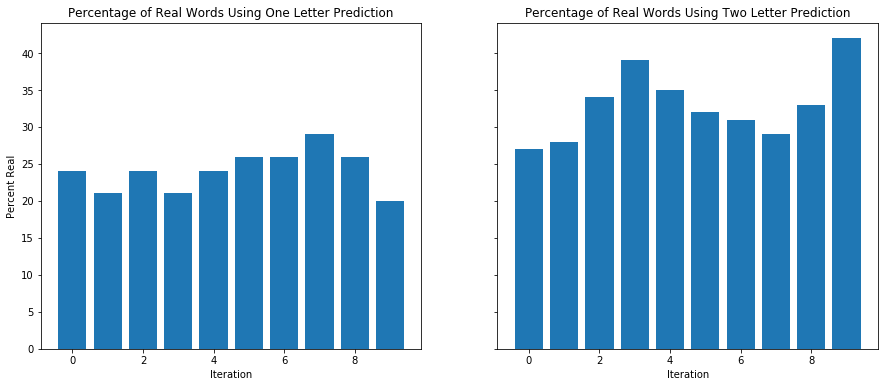

In [37]:
run_x_times(10)

After running each function ten times, the two letter prediction is almost 10% better on average than the one letter prediction at making real words! 

# Sentence Prediction#

To produce random sentences, we need to completely modify our method. We need unique words in the constitution, not characters. There are significantly more unique words than characters, so they cannot be mapped easily to integers and representing the combinations of them with matrices is not realistic. To solve this, we will use a weighted, directed graph. 

First, let's create a graph from our short constitution file so we can visualize it. To get the individual words, we can use the `split` command. This will separate strings into a list by white space. Because we want to treat punctuation as a word, we need to add white space to either side of punctuation so `split` knows it is a word. We can add white space using `replace`.

In [38]:
# Separating the single line constitution test file into a list of words

testtest = text_short.replace(".", " . ") \
           .replace(",", " , ") \
           .replace(";", " ; ") \
           .replace(":", " : ").split() # remove excess white spaces

In [39]:
# First line of constitution separated by words
testtest

['We',
 'the',
 'People',
 'of',
 'the',
 'United',
 'States',
 ',',
 'in',
 'Order',
 'to',
 'form',
 'a',
 'more',
 'perfect',
 'Union',
 ',']

We have a beautiful list of words, so let's make a graph out of them. The overall method is the same as the one-letter method, but with words rather than characters. We need to track only the immediately previous word. The nodes of the graph will be the unique words in the constitution. On every loop, we will add an edge between the previous and current words. If this edge already exists (that exact combination of words was already seen), we increment the "count" weight for the edge.

Building a graph this way with the short file will allow us to visualize the graph and make sure it looks correct.

In [40]:
# Building a directed graph from the single-line constitution

G_test = nx.DiGraph()
previous = None
for current in testtest: # loop through every word
    if not previous:
        previous = current
    else:
        # edge already exists
        if G_test.has_edge(previous,current):
            G_test.get_edge_data(previous,current)["count"] += 1 #increment edge weight
        # edge doesn't exist
        else:
            G_test.add_edge(previous,current,count=1)
        previous = current

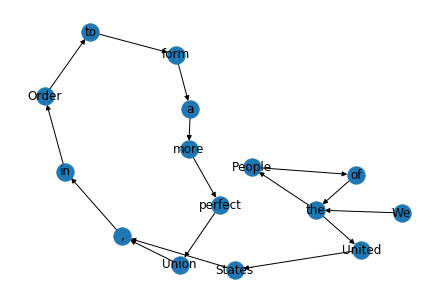

In [41]:
nx.draw(G_test, with_labels=True)

This looks like what we want, so we can repeat the procedure with the full constitution.

In [42]:
# Separating the entire constitution into a list of words, where punctuation is treated as a word

text_sentences = text.replace(".", " . ") \
           .replace(",", " , ") \
           .replace(";", " ; ") \
            .replace(")", " ) ") \
            .replace("(", " ( ") \
           .replace(":", " : ").split() # remove excess white spaces

In [43]:
# Creates a directed graph from the constitution text file 

def make_graph():
    G = nx.DiGraph()
    previous = None
    for current in text_sentences: # loop through every word
        if not previous:
            previous = current
        else:
            # edge already exists
            if G.has_edge(previous,current):
                G.get_edge_data(previous,current)["count"] += 1 # increment edge weight
            # edge doesn't exist
            else:
                G.add_edge(previous,current,count=1)
            previous = current
    return G

In [44]:
G = make_graph()

To generate a random sentence from this graph, we need to choose a start word and follow the graph using the edge weights as probabilities. Because we're looping through the data structure that contains the weights to produce the sentence - as opposed to the word prediction, where we do not loop through the probability matrix - we can calculate the probabilities right before we choose the next word. 

To use `random.choice`, we need a list to choose from and a list of probabilities. The list to choose from is the neighbors of each node, but `G.neighbors` will give us an iterable object over those neighbors, not a list. So, for each node, we have to loop through the neighbors to create a neighbor list and a weight list (which will become the probability list).

After making these lists, we can calculate the probabilities by dividing each weight by the sum of the weights. Then, we can use `random.choice` to choose a neighbor, and we append that neighbor - that word - to a "sentence" array.  

Similarly to the word prediction, we will stop looping (choosing neighbors) once we see an "end character." In this case, the only end character is a period, because the other punctuation could be within a sentence. This works great until we run into a number followed by a period. The constitution lists points this way:   
    
    "Amendment 21 1. The eighteenth article of amendment to the Constitution of the United States is hereby repealed."
    

In this scenario, we don't want the sentence to stop after "1." because that would not be very interesting. So let's add a condition to the `while` loop that tells it to keep looping if the previous word was a number between one and six. ("1" through "6" are the only numbers that precede a period in the constitution.)

In [45]:
# Function to generate a random sentence with the passed in starting word

def make_sentence(start_word):
    word = start_word
    sentence = []
    sentence.append(word) # add starting word to our sentence
    previous = word
    numbers = ['1','2','3','4','5','6'] # numbers before a period
    
    while word != '.' or previous in numbers:
        previous = word
        neighbors = G.neighbors(word)
        neighbor_list = []
        weights = []
        for v in neighbors:
            weights.append(G.get_edge_data(word,v)["count"]) # add edge weight to weight list
            neighbor_list.append(v) # add node to neighbor list
        probs = [float(i)/sum(weights) for i in weights] # calculate probabilities
        word = np.random.choice(neighbor_list, p=probs) # randomly select word from neighbors
        sentence.append(word)
        
    return sentence

Let's test this function with the starting word "We".

In [46]:
# Creating a random sentence starting with "We
sen = make_sentence("We")
print(sen)

['We', 'have', 'devolved', 'upon', 'them', 'to', 'the', 'United', 'States', 'respectively', ',', 'if', 'no', 'Warrants', 'shall', 'then', 'from', 'whatever', ',', 'as', 'President', 'whenever', 'the', 'Time', 'for', 'a', 'redress', 'of', 'such', 'Exceptions', ',', 'be', 'a', 'Journal', 'of', 'Nations', ',', 'he', 'shall', 'not', 'in', 'the', 'number', 'of', 'their', 'Offices', 'during', 'the', 'United', 'States', 'concerned', 'as', 'the', 'Militia', ',', 'be', 'increased', 'nor', 'excessive', 'fines', 'imposed', 'on', 'the', 'Day', 'shall', 'take', 'the', 'President', 'shall', 'be', 'removed', ',', 'as', 'may', 'by', 'law', 'provide', ',', 'and', 'with', 'the', 'other', 'Officers', 'of', 'the', 'United', 'States', 'shall', 'choose', 'a', 'President', 'more', 'than', 'two', 'thirds', 'of', 'the', 'whole', 'Number', 'of', 'and', 'Vice-President', 'of', 'certain', 'rights', ',', 'and', 'Felonies', 'committed', 'within', 'every', 'subsequent', 'Term', 'of', 'the', 'people', '.']


Looks nice and meaningless. Let's write a function to increase readibility using `join` and `replace` once again. 

In [47]:
# Converts a list of words to a readable sentence

def list_to_sentence(sentence):
    s = ' '
    a = s.join(sentence)
    a = a.replace(" .", ". ") \
               .replace(" , ", ", ") \
               .replace(" ; ", "; ") \
                .replace(" : ", ": ") \
                .replace(" ) ", ") ") \
                .replace(" ( ", " (") 
    return a

In [48]:
list_to_sentence(sen)

'We have devolved upon them to the United States respectively, if no Warrants shall then from whatever, as President whenever the Time for a redress of such Exceptions, be a Journal of Nations, he shall not in the number of their Offices during the United States concerned as the Militia, be increased nor excessive fines imposed on the Day shall take the President shall be removed, as may by law provide, and with the other Officers of the United States shall choose a President more than two thirds of the whole Number of and Vice-President of certain rights, and Felonies committed within every subsequent Term of the people. '

As a simple test to make sure everything is set up correctly, let's find a sentence that starts with "Amendment." "Amendment" is always followed by a number in the constitution, so everytime we run this, the first two words should be "Amendment" and some number. Also, we can produce random nonsense amendments this way!

In [49]:
# Generating a random Amendment
list_to_sentence(make_sentence("Amendment"))

'Amendment 12 The United States, Maryland six years of all Duties of Election to the common defence, whenever two years of such Part of the executive Departments, after receipt of the States and House, it shall be a majority of the Territory or prosecuted against him, or Compact with themselves. '

Finally, rather than feeding the function a starting word every time, we want it to pick a starting word for us. In the constitution, sentences begin either (1) following a period (aka another sentence) or (2) following a number (aka an amendment title).

So, our starting words will be a list of unique words that follow a period or a number and we will randomly choose a word from this list each time we generate a sentence. Getting the words that follow a sentence is easy using `neighbors()`. We'll loop through all our "end words" (numbers and period) and add their neighbors to a starting word set.

In [50]:
# Creating a set of possible starting words for random sentences

start_word_list = set() # use a set to store only unique words
precedes_sentence = [str(i) for i in range(1,28)] # numbers between 1 and 27 (# of amendments)
precedes_sentence.append('.') # add period

# Adding all the words that follow numbers and periods to the set
for value in precedes_sentence:  
    for v in G.neighbors(value):
        start_word_list.add(v)

In [51]:
print(start_word_list)

{'Whenever', '1', 'Thereafter', '.', 'Congress', 'No', 'Representatives', 'Done', 'North', 'Immediately', 'New', 'The', 'Sections', 'In', '4', 'Before', '6', 'Treason', 'If', 'When', '5', 'Full', '"', ',', 'shall', 'Article', 'Section', 'Amendment', 'They', 'and', 'A', 'All', 'And', 'Judgment', 'Neither', 'He', '2', '3', 'Excessive', 'Each', 'Thereupon', 'This', 'But', 'George', 'Every', 'After'}


This list looks good for starting words except for a couple punctuation marks and the lowercase words "and" and "shall" that snuck in. Let's delete those.

In [52]:
# Removing words we don't want to start sentences with

start_word_list.remove(',')
start_word_list.remove('"')
start_word_list.remove('.')
start_word_list.remove('and')
start_word_list.remove('shall')

Alright, let's hallucinate some sentences!

In [53]:
# Printing 10 random sentences

for i in range(10):        
    start_word = np.random.choice(list(start_word_list))
    s = make_sentence(start_word)
    print(list_to_sentence(s))
    print("\n")

If, at the Rules concerning Captures on the United States, nor any person constitutionally ineligible to vote by appropriate legislation. 


Excessive bail shall name in one vote. 


1.  This amendment shall have qualified; nor shall be preserved, it shall not have been duly convicted of Money to the State, with foreign State, within, but no person holding any subject to the highest on the highest numbers not be vested in Consequence of votes as the States, or term of the people thereof, unless on such inferior Courts, the Person holding Elections for their Judgment and Pardons for the Case of Representatives shall not delegated to hold any of the President and the President shall by election of the Members present the land or pay Duties in their Enemies, or a President whenever the United States, Alliance, then be by a Term of Electors appointed to Prejudice any State may be inoperative unless it, and excluding Indians not exceeding ten dollars, the twelfth article shall exceed one St

These sentences look great! And they can get shockingly long because periods are not overly common in the constitution. Some improvements that could be made if this problem were to be extended:

 - Classifying words as their part of speech to create sentences that have a greater chance of making sense. 
 - Adding logic to ensure that punctuation is used correctly. For example, never using a end parentheses before a beginning one, always closing parantheses, and always using two sets of quotation marks. 
 - Using numbers more appropriately. Numbers are often followed by other numbers, which doesn't make much sense. 
 - If these algorithms were to be applied to other documents, several changes would have to be made because I used a couple tricks that apply only to this specific document. For example, I used "end characters" and starting letters and words based on the constitution. A more robust program might pull these from the document automatically. 


Thank you!